In [1]:
import os
import json
import random
import torch
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dotmap import DotMap
from tqdm import tqdm

import sys
sys.path.append('../../')

from src.datasets.dataset_lm import get_dataloader, get_dataset
from src.utils.utils import load_config
from src.models.lm.model import LSTMLM

In [2]:
def seed_everything(seed):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [6]:
config_path = '../../configs/lm/char_lstm_l1.json'
config = load_config(config_path)
seed_everything(config.seed)
# if args.gpuid >= 0:
config.gpu_device = 0

# if config.cuda:
#     device = torch.device('cuda:{}'.format(config.gpu_device))
# else:
device = torch.device('cpu')

In [10]:
test_dataset = get_dataset(config, 1, 'test', ["sub5"], ['M1'])

test_loader = get_dataloader(test_dataset, config, 'test')

100%|██████████| 13/13 [00:00<00:00, 15.85it/s]


In [11]:
self = LSTMLM(config, device)

path = "/mnt/aoni04/jsakuma/development/ATR-Trek/exp/lm_cv2/char/M1/lstm_l1_lr4_weighted3_parallel/cv1/best_val_bacc_model.pth"

self.load_state_dict(torch.load(path))#, strict=False)
self.to(device)

LSTMLM(
  (lm): LSTMModel(
    (embed): Embedding(2307, 300, padding_idx=0)
    (lstm): LSTM(300, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=2307, bias=True)
    (criterion): CrossEntropyLoss()
  )
)

In [12]:
path = '/mnt/aoni04/jsakuma/development/espnet-g05-1.8/egs2/atr6/asr1/data/my_token_list/char/tokens.txt'
with open(path) as f:
    lines =f.readlines()
    
tokens = [line.split()[0] for line in lines]

def token2idx(token): 
    if token != token or token == '':
        return [0]
    
    token = token.replace('<eou>', '')
    idxs = [tokens.index(t) for t in token]+[len(tokens)-1]
    
    return idxs

def idx2token(idxs): 
    token = [tokens[idx] for idx in idxs]
    
    return token


# bAcc

In [13]:
EOU=2306

tpr, tnr, bAcc = 0, 0, 0
total = 0
for batch in tqdm(test_loader):
    texts = batch[0]
    phons = batch[1]
    idxs = batch[2]
    input_lengths = batch[3]
    indices = batch[4]    
#     contexts = batch[5]
#     context_lengths = batch[6]
#     pre_spks = batch[6]
    batch_size = len(indices)
    
    inputs = idxs[:, :-1].to(self.device)
    targets = idxs[:, 1:].to(self.device)

    with torch.no_grad():
        outputs = self.lm(inputs, input_lengths)#, contexts, context_lengths)    
        _, preds = torch.max(outputs.data, -1)
        
    for i in range(batch_size):
        prd = preds[i][:input_lengths[i]].detach().cpu()
        trt = targets[i][:input_lengths[i]].detach().cpu()

        TP, FP, FN, TN = 0, 0, 0, 0
        for j in range(len(prd)):
            if trt[j]==EOU and prd[j]==EOU:
                TP+=1
            elif trt[j]==EOU and prd[j]!=EOU:
                FN+=1
            elif trt[j]!=EOU and prd[j]==EOU:
                FP+=1
            else:
                TN+=1

        if TP+FN>0:
            tpr += TP / (TP+FN)            
        else:
            tpr += 0
            
        #if TP<=0:
        #print(indices[i], texts[i])
            
            
        tnr += TN / (TN+FP)
        bAcc += (tpr+tnr)/2

    total+=batch_size
    
tpr = tpr / total
tnr = tnr / total
bAcc = (tpr+tnr)/2
print(tpr)
print(tnr)
print(bAcc)

100%|██████████| 3/3 [00:00<00:00,  5.36it/s]

0.7906976744186046
0.9262737369212245
0.8584857056699146


In [14]:
import torch.nn.functional as F
import math
EOU=2306

tpr, tnr, bAcc = 0, 0, 0
total = 0
total_loss = 0
for batch in tqdm(test_loader):
    texts = batch[0]
    phons = batch[1]
    idxs = batch[2]
    input_lengths = batch[3]
    indices = batch[4]    
#     contexts = batch[5]
#     context_lengths = batch[6]
#     pre_spks = batch[6]
    batch_size = len(indices)
    
    inputs = idxs[:, :-1].to(self.device)
    targets = idxs[:, 1:].to(self.device)

    with torch.no_grad():
        outputs = self.lm(inputs, input_lengths)#, contexts, context_lengths)    
        _, preds = torch.max(outputs.data, -1)
        
        out = []
        label = []
        for i in range(batch_size):
            out.append(outputs[i, :input_lengths[i], :][-10:, :])
            label.append(targets[i, :input_lengths[i]][-10:])
        
        loss = F.cross_entropy(torch.cat(out).view(-1, 2307), torch.cat(label).reshape(-1))
        total_loss += loss.item()
        total+=batch_size
        
ppl = math.exp(total_loss / total)
print(ppl)

100%|██████████| 3/3 [00:00<00:00,  6.00it/s]

1.1578515263519427


# Algorithm

In [15]:
from queue import PriorityQueue
import operator

In [16]:
class BeamSearchNode(object):
    def __init__(self, hidden_state, previousNode, wordId, prob, length):
        '''
        :param hiddenstate:
        :param previousNode:
        :param wordId:
        :param logProb:
        :param length:
        '''
        self.hidden_state = hidden_state
        self.prevNode = previousNode
        self.wordid = wordId
        self.prob = prob
        self.leng = length

    def eval(self, alpha=1.0):
        reward = 0
        # Add here a function for shaping a reward

        return self.logp / float(self.leng - 1 + 1e-6) + alpha * reward

In [17]:
MAX_LENGTH = 10
beam_width = 3
EOU_id = 2306 # 1314
eou_probs = []


def get_nodes(inp):
    endnodes = []
    with torch.no_grad():
        #inp = inputs[IDX, :START]
        decoder_output, hidden = self.lm.forward_step(inp.unsqueeze(0))
        prob = torch.softmax(decoder_output, dim=-1)

        eou_probs.append(prob[0][0][2306].item())
        #eou_probs.append(prob[0][0][125].item())

        prob_, indexes = torch.topk(prob, beam_width)
        prob_ = prob_[0][-1] 
        indexes = indexes[0][-1]

        n_end = 0
        cur_nodes = PriorityQueue()
        for i in range(len(indexes)):        
            n = BeamSearchNode(hidden, None, indexes[i], prob_[i], 1)
            cur_nodes.put((-prob_[i], n))

        cnt = 1
        while True:
            if cur_nodes.qsize()== 0: 
                #print('B')
                break

            if cnt >= MAX_LENGTH:
                for bw in range(beam_width):
                #for bw in range(beam_width-n_end):
                    p, cur_node = cur_nodes.get()
                    endnodes.append(cur_node)
                    #print('A')
                break

    #         elif n_end >= beam_width:
    #             break

            nxt_nodes = PriorityQueue()

            eou_prob_tmp = 0
            for bw in range(beam_width):
            #for bw in range(beam_width-n_end):
                if cur_nodes.qsize()== 0:            
                    break

                p, cur_node = cur_nodes.get()            
                idx = cur_node.wordid
                hidden = cur_node.hidden_state

                if cur_node.wordid.item() == EOU_id:
                    n_end+=1
                    endnodes.append(cur_node)
                    continue

                decoder_output, hidden = self.lm.forward_step(idx.unsqueeze(0).unsqueeze(0), hidden)
                prob = torch.softmax(decoder_output, dim=-1)

                prob_, indexes = torch.topk(prob, beam_width)
                prob_ = prob_[0][-1] 
                indexes = indexes[0][-1]

                for i in range(len(indexes)):                                    
                    #n = BeamSearchNode(hidden, cur_node, indexes[i], cur_node.prob+prob_[i]/float(cnt+1), cnt+1)
                    n = BeamSearchNode(hidden, cur_node, indexes[i], cur_node.prob*prob_[i], cnt+1)
                    nxt_nodes.put((-prob_[i], n))

            cur_nodes = nxt_nodes                
            cnt += 1
            
    return  endnodes

In [19]:
from src.datasets.dataset_timing import get_dataloader, get_dataset

config_path = '../../configs/timing/timing_proposed_s1234.json'
config2 = load_config(config_path)

test_dataset2 = get_dataset(config2, 1, split='test', subsets=["M1_all"], speaker_list=['M1'])

100%|██████████| 90/90 [00:29<00:00,  3.05it/s]


In [20]:
def clean(sentence):
    for remove in ["はいはいはいはい", "はいはいはいは", "はいはいはい", "はいはいは", "はいはい", "はいは", "はい", "は"]:  
        if sentence != remove and sentence[-len(remove):]==remove:
            sentence = sentence[:-len(remove)]
            break

    return sentence

def clean_id(sentence):
    for remove in [[22,3,22,3,22,3,22,3], [22,3,22,3,22,3,22], [22,3,22,3,22,3], [22,3,22,3,22], [22,3,22,3], [22,3,22], [22,3], [22]]:  
        if sentence != remove and sentence[-len(remove):]==remove:
            sentence = sentence[:-len(remove)]
            break

    return sentence

In [21]:
data = test_dataset2.data
total = len(data)
score_list = []
text_list = []
gen_list = []
for j in tqdm(range(total)):
    texts = data[j]['text']
    idxs = data[j]['idx']
#     context = data[j]['context']
#     context_length = len(context)

    target = data[j]['target']
    timing = np.where(target==1)[0][0]

    utt = []
    id_list = []
    con_list = []
    len_list = []
    nums = []
    pre = ''
    ipre = 0
    time_list = []
    for i, text in enumerate(texts):
        if timing<i:
            utt.append(texts[ipre+8])
            nums.append(len(texts[ipre+8]))
            id_list.append(idxs[ipre+8])
#             con_list.append(context)
#             len_list.append(context_length)
            time_list.append((ipre+8)*50)
            eou = ipre
            break

        if text != pre:
            utt.append(clean(text))
            #utt.append(text)
            nums.append(len(text))
            id_list.append(clean_id(idxs[i]))
#             con_list.append(context)
#             len_list.append(context_length)
            #id_list.append(idxs[i])
            time_list.append(i*50)
            pre = text
            ipre = i
    
    tt = np.array([eou*50 - t for t in time_list])
    scores = []
    asr_results = []
    gen_results = []
    for i in [1000, 400, 200, 50, -400]:
        if i == -400:
            idx = len(tt)-1
        else:
            idx = np.where(tt<i)[0][0]-1

        inp = torch.tensor(id_list[idx]).to(device)
        endnodes = get_nodes(inp) 
                    
        asr_results.append(utt[idx])
            
        utterances = []
        n_score = np.zeros(MAX_LENGTH)
        total = 0
        for node in endnodes:
            utterance = []
            n = node
            score = n.prob
            while n is not None:
                utterance.append(n.wordid.item())        
                n = n.prevNode        

            utterances.append(utterance[::-1])
            n_score[len(utterance)-1:]+=score.item()
            total += score.item()
            
        scores.append(n_score)
        gen_results.append(utterances)
        
#     flg = False
#     for gens in gen_results[-1]:
#         if gens[-1]==2306:
#             flg=True
#             break
                
#     if flg:
    scores= np.vstack(scores)
    score_list.append(scores)  
    text_list.append(asr_results)
    gen_list.append(gen_results)
    #     plt.plot(n_score, label='{}ms'.format(i), marker='x')

    # plt.legend()
    # plt.xlabel("Num of words")
    # plt.ylabel("prob")

100%|██████████| 247/247 [00:32<00:00,  7.72it/s]


In [22]:
i=3
gen_list[i][-1], score_list[i][-1], text_list[i]

([[2306],
  [3, 2306],
  [19, 2306],
  [19, 2, 2306],
  [19, 2, 6, 2306],
  [19, 2, 37, 805, 3, 12, 8, 10, 2306],
  [19, 2, 37, 442, 27, 703, 12, 7, 24, 20],
  [19, 2, 37, 442, 27, 703, 12, 7, 3, 16],
  [19, 2, 37, 442, 27, 703, 12, 7, 3, 24]],
 array([0.3800126 , 0.43200709, 0.4329857 , 0.4338505 , 0.4338505 ,
        0.4338505 , 0.4338505 , 0.4338505 , 0.4338816 , 0.43388457]),
 ['きとかあの新大阪とかその辺り',
  'きとかあの新大阪とかその辺りなります',
  'きとかあの新大阪とかその辺りなります',
  'きとかあの新大阪とかその辺りなります',
  'きとかあの新大阪とかその辺りなりますはい'])

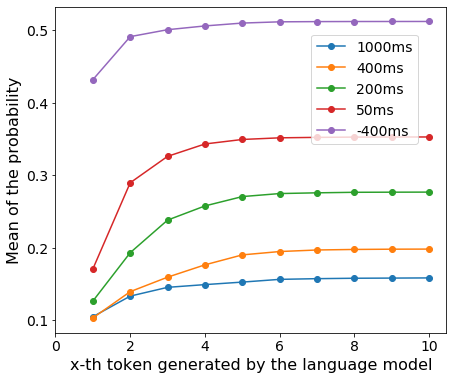

In [23]:
SIZE=16

plt.figure(figsize=(7, 6))

mean = np.mean(score_list, axis=0)
var = np.var(score_list, axis=0)

# ax1 = plt.subplot(1, 2, 1)
# ax2 = plt.subplot(1, 2, 2)

for i, t in enumerate([1000, 400, 200, 50, -400]):
    plt.plot(np.arange(1, 11), mean[i], label='{}ms'.format(t), marker='o')
#     ax2.plot(np.arange(1, 11), var[i], label='{}ms'.format(t), marker='o')

plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=2, fontsize=14)
# ax1.title("variance")
plt.xlabel("x-th token generated by the language model", fontsize=SIZE)
plt.ylabel("Mean of the probability", fontsize=SIZE)
plt.xticks(np.arange(0, 12, 2))
plt.tick_params(labelsize = 14)

plt.show()